In [1]:
#import the relevant configuration file
from configfiles import field5config as fieldconfig 
#from configfiles import Hnorthconfig as fieldconfig 
#from configfiles import archSEconfig as fieldconfig 

ModuleNotFoundError: No module named 'configfiles'

In [324]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

In [325]:
#change directory to data location - provide alternate if working between two different pc's
try:
    os.chdir(fieldconfig.dpath)
except:
    os.chdir(fieldconfig.dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(fieldconfig.fname)
header=hdu[0].header
ims=hdu[0].data
#np.shape(ims)
data=ims[0]
varmap=ims[1]
tmap=ims[2]
#wcsmap = WCS(header)
hdu.close()

#hack to make SOFIA wcs header work correctly with astropy.wcs
hdu[0].header['NAXIS']=2
wcsmap=WCS(hdu[0].header)

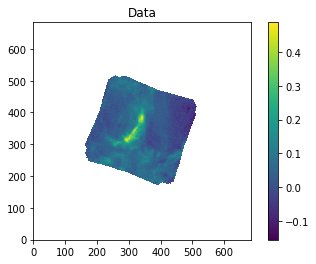

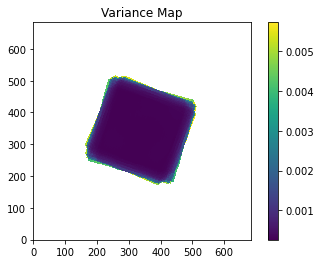

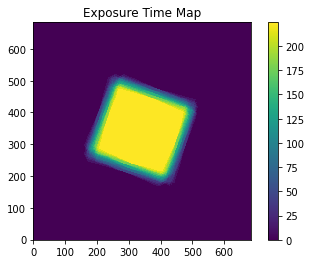

In [326]:
#take a quick look at the maps that were loaded in 
plt.figure()
plt.title('Data')
plt.imshow(data,origin='lower',interpolation='none')
plt.colorbar()
#plt.clim(0.0,0.1)
plt.show()

plt.figure()
plt.title('Variance Map')
plt.imshow(varmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Exposure Time Map')
plt.imshow(tmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

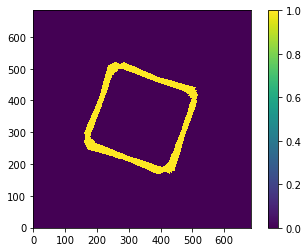

In [327]:
#create mask for edges of field where less integration time was collected
tmapnorm=tmap/np.max(tmap) #normalize the exposure time map
mask=np.where(tmapnorm<fieldconfig.tmapnormcut,tmapnorm,0).astype('bool') #create mask for any locations with less than 50% of max exposure time -Can be modified as needed
#the above can be adjusted if there are obvious sources near the edges of the map

#plot any of the mask to verify
plt.figure()
plt.imshow(mask,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [328]:
#create background model for image using median method
bkg_estimator = MedianBackground() #MMMBackground() #SExtractorBackground() #MedianBackground()
bkg_data = Background2D(data,(fieldconfig.bkgbox, fieldconfig.bkgbox), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
data_bkgsub = data - bkg

#set detection threshold for source finding based on modeled background rms
threshold = 3.0*bkg_rms

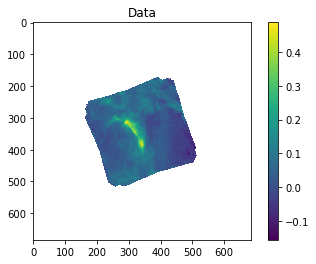

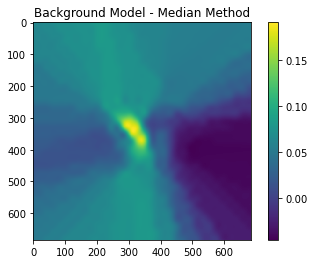

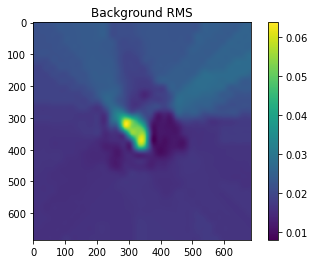

In [329]:
#take a look at data and bakground model images
plt.figure()
plt.title('Data')
plt.imshow(data,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background Model - Median Method')
plt.imshow(bkg,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background RMS')
plt.imshow(bkg_rms,interpolation='none')
plt.colorbar()
plt.show()

In [330]:
#do source detection. A 3x3 FWHM gaussian is used to smooth image prior to detection
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data_bkgsub, threshold, mask=mask, npixels=5, filter_kernel=kernel)

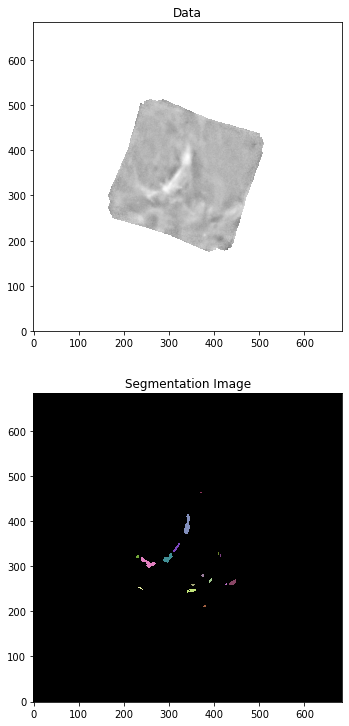

In [331]:
#removed labels that exist in masked region
if fieldconfig.usemask2:
    mask2=np.zeros(np.shape(mask))
    for lim in fieldconfig.m2limits:
        mask2[lim[0]:lim[1],lim[2]:lim[3]]=1
    segm.remove_masked_labels(mask2.astype('bool'))

#make plot of segmentation image to show detected sources
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')
plt.show()

In [332]:
#now lets look at building a catalog and associated table from the seg map
cat = SourceCatalog(data_bkgsub, segm,background=bkg,wcs=wcsmap) #can also take in error and bkg measurements - this is done later

#specify the columns that we want for our table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl = cat.to_table(columns)

#display table below
tbl

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,379.4966805674489,211.98574839134275,"266.43246338377656,-28.874254834657812",0.01224512667027865,0.07244003551912026,1.5936807814206457,22.0,1.4089005281722466,1.061475504247498,31.05037637545494,0.6058702163710423,-0.33914363705814,0.7854318241652394,0.6575544916148037,0.24659301134300793,1.327303854431427,2.93726916081795,5.088545548719056,nan,2.8486836002543585,1.7702939909730577,nan
2,351.045426273427,246.56167162161506,"266.4393948534123,-28.86687894836748",0.03516551516698346,0.07462867801000429,8.059897225080464,108.0,5.395459579000683,1.7644402456904047,13.121091487040413,0.04913400402599724,-0.12683828834253358,0.3064250959346655,0.9450163238148329,0.6729768391634945,3.0578873907342228,9.452224407206536,20.785085298157497,nan,2.697464664951362,6.284003164888886,nan
3,237.31610296760397,252.0986766576128,"266.4670993077859,-28.865695416455747",0.08425559163279892,0.08376412114948582,2.512923634484575,30.0,2.881368381339625,0.8429426382984901,-26.129456959889247,0.3700481257747404,1.017666644022458,1.1577566171857703,0.9562504060043472,0.7074505836332584,3.418225927158899,4.998888632599752,18.690136985592446,nan,3.4376311149818526,2.7820531512944244,nan
4,353.6136338084212,258.7796425211022,"266.438769312116,-28.864272434861334",0.04132099201727368,0.07436697429797831,2.0822752803433926,28.0,2.3245753295963394,1.2337893152444208,-22.20191773811364,0.25243677109321444,0.330171481143837,0.5895516398541839,0.8475227823602305,0.469240983703175,1.8840942297638779,4.382081115754246,19.849252571579427,nan,3.569597143984231,1.8349173575769873,nan
5,428.3080682539926,259.46682128943,"266.42057405234334,-28.86412418495037",0.0242179600723873,0.03770143911967616,0.6032230259148186,16.0,1.4937187143488386,1.0385802032680003,-32.47342787629077,0.5862417353794945,0.43383888193563613,0.7890342442102831,0.7187211989591146,0.30470161932680095,1.4382314525625444,3.029329522554616,10.813983148632612,nan,3.571553727070014,1.1221124156149322,nan
6,442.41485759293073,264.13906328112233,"266.4171379335051,-28.863126853981893",0.03259581016615801,0.034171870479533246,4.168968198503056,122.0,4.5730155360516855,2.1216391938392722,31.885133798778657,0.09646089366906725,-0.15638543840562188,0.17351289688938257,0.8858626887726303,0.5360524850368029,2.155416222197732,8.394169506597288,60.334381359591475,nan,3.4082337064553023,11.334730463420353,nan
7,392.70334466840666,268.5116506281426,"266.42924745584776,-28.862195713624384",0.04023072226350172,0.03666565017091537,1.7966168583748532,49.0,2.6776129015315924,1.4181428201336375,57.88772965801636,0.3961395419513911,-0.32216069709182793,0.24057117384362697,0.8482290832881291,0.47037048584488783,1.8881122997747644,5.045236955069912,12.32348226522279,nan,2.934347614052567,3.66710183905385,nan
8,375.2868302431476,279.0355068778332,"266.4334901533507,-28.85995095646939",0.05186236830044355,0.03689732072428137,1.512790149695536,41.0,1.913586538918714,1.6536110572021367,-83.96114086114265,0.3646819255083843,0.01937928662656163,0.27411380215019515,0.5032475530094401,0.135857708250539,1.1572168259182112,4.211193551064287,11.231112282329688,nan,3.0381471291039275,2.995039158814291,nan


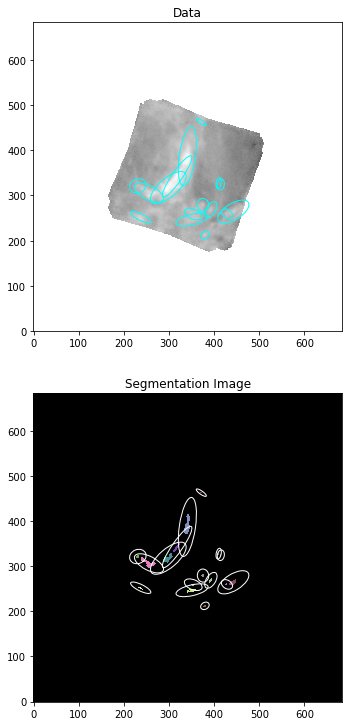

In [333]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in cat.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

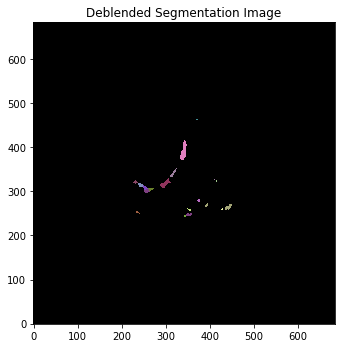

In [334]:
#lets take a look at deblending sources
segm_deblend = deblend_sources(data_bkgsub, segm, npixels=5,filter_kernel=kernel, nlevels=64,contrast=0.001)

#remove any sources that should be masked (mask3) 
if fieldconfig.usemask3:
    mask3=np.zeros(np.shape(mask))
    for lim in fieldconfig.m3limits:
        mask3[lim[0]:lim[1],lim[2]:lim[3]]=1
    segm_deblend.remove_masked_labels(mask3.astype('bool'))

#plot the deblended image
plt.figure(figsize=(5.4, 8.5))
plt.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')
plt.title('Deblended Segmentation Image')
plt.show()

In [335]:
#now lets look at building a catalog and table from the deblended seg map
catde = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,wcs=wcsmap)

#define which columns we want to have in the table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl_deblend = catde.to_table(columns)

#display table
tbl_deblend

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,379.4966805674489,211.98574839134275,"266.43246338377656,-28.874254834657812",0.01224512667027865,0.07244003551912026,1.5936807814206457,22.0,1.4089005281722466,1.061475504247498,31.05037637545494,0.6058702163710423,-0.33914363705814,0.7854318241652394,0.6575544916148037,0.24659301134300793,1.327303854431427,2.93726916081795,5.088545548719056,nan,2.8486836002543585,1.7702939909730577,nan
2,237.31610296760397,252.0986766576128,"266.4670993077859,-28.865695416455747",0.08425559163279892,0.08376412114948582,2.512923634484575,30.0,2.881368381339625,0.8429426382984901,-26.129456959889247,0.3700481257747404,1.017666644022458,1.1577566171857703,0.9562504060043472,0.7074505836332584,3.418225927158899,4.998888632599752,18.690136985592446,nan,3.4376311149818526,2.7820531512944244,nan
3,353.6136338084212,258.7796425211022,"266.438769312116,-28.864272434861334",0.04132099201727368,0.07436697429797831,2.0822752803433926,28.0,2.3245753295963394,1.2337893152444208,-22.20191773811364,0.25243677109321444,0.330171481143837,0.5895516398541839,0.8475227823602305,0.469240983703175,1.8840942297638779,4.382081115754246,19.849252571579427,nan,3.569597143984231,1.8349173575769873,nan
4,428.3080682539926,259.46682128943,"266.42057405234334,-28.86412418495037",0.0242179600723873,0.03770143911967616,0.6032230259148186,16.0,1.4937187143488386,1.0385802032680003,-32.47342787629077,0.5862417353794945,0.43383888193563613,0.7890342442102831,0.7187211989591146,0.30470161932680095,1.4382314525625444,3.029329522554616,10.813983148632612,nan,3.571553727070014,1.1221124156149322,nan
5,442.41485759293073,264.13906328112233,"266.4171379335051,-28.863126853981893",0.03259581016615801,0.034171870479533246,4.168968198503056,122.0,4.5730155360516855,2.1216391938392722,31.885133798778657,0.09646089366906725,-0.15638543840562188,0.17351289688938257,0.8858626887726303,0.5360524850368029,2.155416222197732,8.394169506597288,60.334381359591475,nan,3.4082337064553023,11.334730463420353,nan
6,392.70334466840666,268.5116506281426,"266.42924745584776,-28.862195713624384",0.04023072226350172,0.03666565017091537,1.7966168583748532,49.0,2.6776129015315924,1.4181428201336375,57.88772965801636,0.3961395419513911,-0.32216069709182793,0.24057117384362697,0.8482290832881291,0.47037048584488783,1.8881122997747644,5.045236955069912,12.32348226522279,nan,2.934347614052567,3.66710183905385,nan
7,375.2868302431476,279.0355068778332,"266.4334901533507,-28.85995095646939",0.05186236830044355,0.03689732072428137,1.512790149695536,41.0,1.913586538918714,1.6536110572021367,-83.96114086114265,0.3646819255083843,0.01937928662656163,0.27411380215019515,0.5032475530094401,0.135857708250539,1.1572168259182112,4.211193551064287,11.231112282329688,nan,3.0381471291039275,2.995039158814291,nan
8,231.00805814916552,321.2576610643135,"266.46863216365153,-28.85094120850555",0.07308293242218006,0.040748356291427326,1.9966694582799391,49.0,2.243113010895114,1.8585720480218362,20.978626275145334,0.21037776191093732,-0.06067287477934765,0.2778630019568508,0.559888188492546,0.1714318275563952,1.2069012946162416,4.850542343055901,16.401492484673547,nan,3.3281336150362995,2.919135509004263,nan


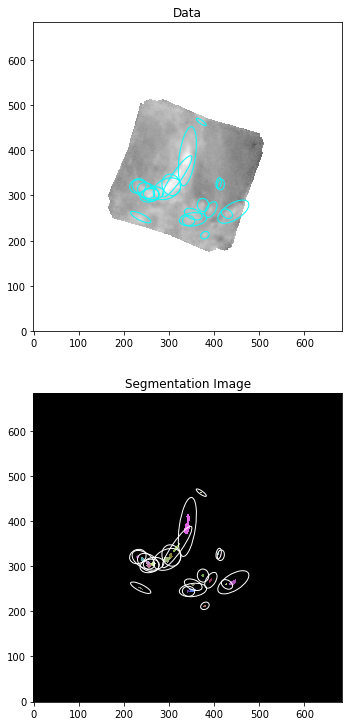

In [336]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm_deblend.make_cmap(seed=123)
ax2.imshow(segm_deblend, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in catde.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

In [337]:
#what if we wanted to include errors? - Not completely sure this is implemented correctly for our observations, but we'll use it for now...
calfactor = header['CALFCTR'] # units are (Me/sec/Jy)
gainfactor=tmap*calfactor*1e6 #gain in electrons/Jy
#errormap=calc_total_error(data,bkg,gainfactor) #use the varmap instead. Its probably more appropriate for our data type. 

#now lets look at building a catalog from the seg map
catwerr = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,error=errormap,wcs=wcsmap)
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','background','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']#,'kron_aperture']
tbl2 = catwerr.to_table(columns)

In [338]:
#calculate statistics for background cutouts in table
segbkg_median=[]
segbkg_mean=[]
segbkg_std=[]

#loop through each cutout and use sigma_cliped_stats to get mean, median, and std
for i in range (0,len(tbl2['background'])):
    bkgdata=tbl2['background'][i]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(bkgdata)
    segbkg_median.append(median_sigclip)
    segbkg_mean.append(meansc)
    segbkg_std.append(stdsc)

#add the above calculated information to our table
tbl2['segbkg_mean_sc']=segbkg_mean
tbl2['segbkg_median_sc']=segbkg_median
tbl2['segbkg_std_sc']=segbkg_std  

#remove the 2d background array to tidy up the table
tbl2.remove_column('background')

In [339]:
#calculate noise stats
#sky noise from background
skynoise=np.sqrt(tbl2['segbkg_median_sc']*tbl2['area']/u.pix**2)
#replace any nan values with zero
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#shot noise from the source
sourcenoise=tbl2['segment_flux']

#thermal noise from camera (from error map)
thermalnoise=tbl2['segment_fluxerr']

#total noise
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #includes all noise sources
totalnoise=np.sqrt(thermalnoise+skynoise) #no shot noise -> For some reason this seems to work much better for the apertures. Need to think about why this is a bit more...

#calculate SNR for the segments
tbl2['segmentSNR']=tbl2['segment_flux']/ totalnoise 

#display table
tbl2

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64
1,379.4966805674489,211.98574839134275,"266.43246338377656,-28.874254834657812",0.01224512667027865,0.07244003551912026,1.5936807814206457,22.0,1.4089005281722466,1.061475504247498,31.05037637545494,0.6058702163710423,-0.33914363705814,0.7854318241652394,0.6575544916148037,0.24659301134300793,1.327303854431427,2.93726916081795,5.088545548719056,0.29893115991732255,2.8486836002543585,1.7702939909730577,0.09072471,0.07243394085752719,0.07247108707587416,0.00035183751467558066,1.363747671519362
2,237.31610296760397,252.0986766576128,"266.4670993077859,-28.865695416455747",0.08425559163279892,0.08376412114948582,2.512923634484575,30.0,2.881368381339625,0.8429426382984901,-26.129456959889247,0.3700481257747404,1.017666644022458,1.1577566171857703,0.9562504060043472,0.7074505836332584,3.418225927158899,4.998888632599752,18.690136985592446,0.5629161925569933,3.4376311149818526,2.7820531512944244,0.12878907,0.08365783979899963,0.08363696073028977,0.0006297078398976963,1.7129174464596069
3,353.6136338084212,258.7796425211022,"266.438769312116,-28.864272434861334",0.04132099201727368,0.07436697429797831,2.0822752803433926,28.0,2.3245753295963394,1.2337893152444208,-22.20191773811364,0.25243677109321444,0.330171481143837,0.5895516398541839,0.8475227823602305,0.469240983703175,1.8840942297638779,4.382081115754246,19.849252571579427,0.44504677757627775,3.569597143984231,1.8349173575769873,0.08791475,0.07453552322388272,0.07467596325940266,0.001118807601427565,1.2430931336308424
4,428.3080682539926,259.46682128943,"266.42057405234334,-28.86412418495037",0.0242179600723873,0.03770143911967616,0.6032230259148186,16.0,1.4937187143488386,1.0385802032680003,-32.47342787629077,0.5862417353794945,0.43383888193563613,0.7890342442102831,0.7187211989591146,0.30470161932680095,1.4382314525625444,3.029329522554616,10.813983148632612,0.35785556551655556,3.571553727070014,1.1221124156149322,0.07160131,0.037133923518206095,0.03710128615655504,0.0015044175157394978,1.375793022662001
5,442.41485759293073,264.13906328112233,"266.4171379335051,-28.863126853981893",0.03259581016615801,0.034171870479533246,4.168968198503056,122.0,4.5730155360516855,2.1216391938392722,31.885133798778657,0.09646089366906725,-0.15638543840562188,0.17351289688938257,0.8858626887726303,0.5360524850368029,2.155416222197732,8.394169506597288,60.334381359591475,1.2326987756206547,3.4082337064553023,11.334730463420353,0.24704659,0.03331023108129964,0.03324701303125019,0.004202036005254717,5.464070960734118
6,392.70334466840666,268.5116506281426,"266.42924745584776,-28.862195713624384",0.04023072226350172,0.03666565017091537,1.7966168583748532,49.0,2.6776129015315924,1.4181428201336375,57.88772965801636,0.3961395419513911,-0.32216069709182793,0.24057117384362697,0.8482290832881291,0.47037048584488783,1.8881122997747644,5.045236955069912,12.32348226522279,0.42625505674575603,2.934347614052567,3.66710183905385,0.11772271,0.036806890023087895,0.03671801166275034,0.0026242665331042466,2.6486382322268542
7,375.2868302431476,279.0355068778332,"266.4334901533507,-28.85995095646939",0.05186236830044355,0.03689732072428137,1.512790149695536,41.0,1.913586538918714,1.6536110572021367,-83.96114086114265,0.3646819255083843,0.01937928662656163,0.27411380215019515,0.5032475530094401,0.135857708250539,1.1572168259182112,4.211193551064287,11.231112282329688,0.40089715062150316,3.0381471291039275,2.9950391588142

In [340]:
#now lets look at performing some aperture photometry on the data.... Lets get the source centroids from the segmentaion map table
sourcecoords=tbl2['sky_centroid']

In [341]:
#first let's do some simple annulus extractions...   
radii = [2,4,6,8,10] #define aperture radii & construct apertures (line below)
apertures =[SkyCircularAperture(sourcecoords, r=r*u.arcsec) for r in radii] # for pixels: r=r*u.arcsec*0.786

#do aperture photometry on data using defined apertures 
phot_table = aperture_photometry(data_bkgsub, apertures,wcs=wcsmap,error=errormap,method='exact')

#display phot table
phot_table

id,xcenter,ycenter,sky_center,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,aperture_sum_2,aperture_sum_err_2,aperture_sum_3,aperture_sum_err_3,aperture_sum_4,aperture_sum_err_4
,pix,pix,"deg,deg",,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,379.49668056734714,211.98574839145058,"266.43246338377656,-28.874254834657812",1.7171725170976233,0.08925314786217331,3.613021036478261,0.17797154930340495,4.736329213823481,0.267719713559929,5.264036139924293,0.3588454391169719,4.943679215531624,0.4525229886245081
2,237.31610296758456,252.09867665772504,"266.4670993077859,-28.865695416455747",1.9649910690105725,0.10917783297657198,7.170744237782655,0.21774541800025424,13.575645565376135,0.3284727014110606,19.800579678299165,0.4436976655876999,25.216497327749224,0.5608969232245113
3,353.61363380845853,258.7796425211224,"266.438769312116,-28.864272434861334",1.3506796813503226,0.07669746089048379,4.299630370033676,0.1534163715384829,8.034261650776385,0.2301172674101455,12.922249708953156,0.3067659768478107,19.20494411556151,0.38339348669558326
4,428.30806825397605,259.4668212894235,"266.42057405234334,-28.86412418495037",1.4386524966694356,0.08255090612597735,4.811125279692843,0.16556881076772054,8.821408448447208,0.24989794996918943,12.551246785928612,0.3359158203498724,15.572495736348904,0.42460486034621053
5,442.41485759289196,264.1390632811086,"266.4171379335051,-28.863126853981893",2.193983865570078,0.10254547589078587,7.993926118788841,0.2070545306220824,14.589802172277743,0.31365038876860046,21.012425297870184,0.42499590899232703,27.403814646932325,0.5431538137474096
6,392.70334466839586,268.51165062811555,"266.42924745584776,-28.862195713624384",1.6931695302530936,0.07762034701627948,5.325183681092559,0.15537562082875114,8.774109291761047,0.23309039817689373,11.0432478863206,0.3106963807049217,12.187469060130194,0.3882828738694696
7,375.28683024309976,279.03550687783047,"266.4334901533507,-28.85995095646939",1.6520859936760661,0.07735531612438523,5.02953803963881,0.15463776505169147,7.983853646694868,0.23189998558979036,10.030086509611163,0.30919344689021566,11.231500806318941,0.3863970629845429
8,231.00805814929072,321.2576610642961,"266.46863216365153,-28.85094120850555",1.3023410327948897,0.07724238651410176,4.5902698346876045,0.15437564643449608,8.444643498090691,0.2315040819182952,12.840780577897668,0.30870354381106463,17.186001215739598,0.385992666083676


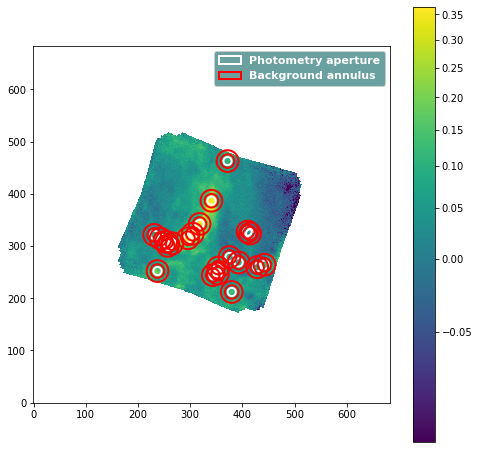

In [342]:
#now try photometry with local background subtraction
aperture2 =SkyCircularAperture(sourcecoords, r=6*u.arcsec) #define aperture
annulus_aperture = SkyCircularAnnulus(sourcecoords, r_in=10*u.arcsec, r_out=16*u.arcsec) #define annulus

#convert to pixel coords for plotting
pix_aperture = aperture2.to_pixel(wcsmap)
pix_annulus_aperture = annulus_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)

ap_patches = pix_aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = pix_annulus_aperture.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

In [343]:
#now lets do robust statistics on the background annuli

#create lists to store information for later
bkg_median=[]
bkg_mean=[]
bkg_std=[]
appmasks=[]

#create mask array for the annuli
annulus_masks = pix_annulus_aperture.to_mask(method='exact')

#for each of the annuli loop through and calculate stats using sigma cliped stats
for mask in annulus_masks:
    annulus_data = mask.multiply(data_bkgsub)
    
    #this is a bit of debugging to handle if the mask array is the wrong shape
    if np.shape(mask.data)[0]==41:
        maskdata=mask.data[:-1,:]
    else:
        maskdata=mask.data
        
    #do statistics
    annulus_data_1d = annulus_data[maskdata > 0]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
    bkg_mean.append(meansc)
    bkg_std.append(stdsc)
    appmasks.append(mask.data)

#store values in numpy arrays
bkg_median = np.array(bkg_median)
bkg_mean = np.array(bkg_mean)
bkg_std = np.array(bkg_std)

In [344]:
#do aperture photometry
phot_table2 = aperture_photometry(data_bkgsub, aperture2,wcs=wcsmap,error=errormap,method='exact') #

#add columns for background information and also background subtracted apertures
phot_table2['ann_bkg_med'] = bkg_median
phot_table2['ann_bkg_mean'] = bkg_mean 
phot_table2['aper_sum_bkgsub_6as'] = (phot_table2['aperture_sum']/pix_aperture.area - phot_table2['ann_bkg_med'])* pix_aperture.area 
phot_table2['aper_sum_bkgsub_err_6as'] = phot_table2['aperture_sum_err'] # should this be modified by bkgsub in some way?
#not sure if the above is right for the error array...

#calculate sky noise for 6 pixel aperture
skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#store per pix sky noise for later
phot_table2['skynoise_pix']=skynoise/pix_aperture.area

#shot noise from the source
sourcenoise=phot_table2['aper_sum_bkgsub_6as']

#thermal noise from camera (from error map)
thermalnoise=phot_table2['aperture_sum_err']

#compute total noise 
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #all noise sources
#totalnoise=np.sqrt(thermalnoise+skynoise) # no shot noise -> For some reason this seems to give more 'reasonable' values. Need to think about why this is a bit more...
totalnoise=np.sqrt((thermalnoise+skynoise)*(1+pix_aperture.area/pix_annulus_aperture.area)) #modified to account for pixel stats

#SNR calc for 6 pixel aperture
phot_table2['aper_snr_6as']=phot_table2['aper_sum_bkgsub_6as']/totalnoise

#display new table
phot_table2

<ipython-input-344-d3b3f743c6c3>:12: RuntimeWarning: invalid value encountered in sqrt
  skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)


id,xcenter,ycenter,sky_center,aperture_sum,aperture_sum_err,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as
,pix,pix,"deg,deg",,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64
1,379.49668056734714,211.98574839145058,"266.43246338377656,-28.874254834657812",4.736329213823481,0.267719713559929,-0.000806746266029086,-0.002051813377294785,4.891020870243957,0.267719713559929,0.0,8.520616620896831
2,237.31610296758456,252.09867665772504,"266.4670993077859,-28.865695416455747",13.575645565376135,0.3284727014110606,0.0009030653805487121,0.0050988820572718425,13.402484950377973,0.3284727014110606,0.0009030653805487121,17.05704623429323
3,353.61363380845853,258.7796425211224,"266.438769312116,-28.864272434861334",8.034261650776385,0.2301172674101455,0.016645843432624492,0.019827455137227987,4.8424612030557395,0.2301172674101455,0.016645843432624492,2.3596253523911677
4,428.30806825397605,259.4668212894235,"266.42057405234334,-28.86412418495037",8.821408448447208,0.24989794996918943,0.0013259001982308652,0.0011316957996660084,8.567170274005907,0.24989794996918943,0.0013259001982308656,10.876149642018303
5,442.41485759289196,264.1390632811086,"266.4171379335051,-28.863126853981893",14.589802172277743,0.31365038876860046,0.013394694579650594,0.017283661936544976,12.021401698642547,0.31365038876860046,0.01339469457965059,6.382869626306899
6,392.70334466839586,268.51165062811555,"266.42924745584776,-28.862195713624384",8.774109291761047,0.23309039817689373,0.0009948074481654046,0.002837869641342884,8.583357355921796,0.23309039817689373,0.0009948074481654049,11.884111359741308
7,375.28683024309976,279.03550687783047,"266.4334901533507,-28.85995095646939",7.983853646694868,0.23189998558979036,1.2230276818242275e-07,0.003991263665562792,7.983830195433187,0.23189998558979036,1.2230276818242272e-07,14.943442516664224
8,231.00805814929072,321.2576610642961,"266.46863216365153,-28.85094120850555",8.444643498090691,0.2315040819182952,0.0018607019855634913,0.003096073389317387,8.087858367037716,0.2315040819182952,0.0018607019855634913,9.504948752479562


In [345]:
#fix id keyword in tbl2 so these can be merged with the phot table results
try:
    tbl2.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

In [346]:
#merge the two photometry tables
merged_table = join(phot_table, phot_table2, keys='id')

#merge the segmentation map table with the combined phot table
merged_table_2 = join(tbl2,merged_table, keys='id')

#drop repeat columns
merged_table_2.remove_columns(['xcenter_1','ycenter_1','xcenter_2','ycenter_2','sky_center_1','sky_center_2','aperture_sum','aperture_sum_err'])

#rename some columns to avoid possible confusion
merged_table_2.rename_column('aperture_sum_0', 'aperture_sum_2as')
merged_table_2.rename_column('aperture_sum_err_0', 'aperture_sum_err_2as')
merged_table_2.rename_column('aperture_sum_1', 'aperture_sum_4as')
merged_table_2.rename_column('aperture_sum_err_1', 'aperture_sum_err_4as')
merged_table_2.rename_column('aperture_sum_2', 'aperture_sum_6as')
merged_table_2.rename_column('aperture_sum_err_2', 'aperture_sum_err_6as')
merged_table_2.rename_column('aperture_sum_3', 'aperture_sum_8as')
merged_table_2.rename_column('aperture_sum_err_3', 'aperture_sum_err_8as')
merged_table_2.rename_column('aperture_sum_4', 'aperture_sum_10as')
merged_table_2.rename_column('aperture_sum_err_4', 'aperture_sum_err_10as')


#compute area for the different size apertures 
ap2area=pix_aperture.area*(2./6.)**2
ap4area=pix_aperture.area*(4./6.)**2
#ap6area=pix_aperture.area*(6./6.)**2
ap8area=pix_aperture.area*(8./6.)**2
ap10area=pix_aperture.area*(10./6.)**2


#calculate local bkg subtracted photometry for the other apertures 
merged_table_2['aper_sum_bkgsub_2as']=(merged_table_2['aperture_sum_2as']/ap2area-merged_table_2['ann_bkg_med'])*ap2area
merged_table_2['aper_sum_bkgsub_4as']=(merged_table_2['aperture_sum_4as']/ap4area-merged_table_2['ann_bkg_med'])*ap4area
#merged_table_2['aper_sum_bkgsub_6as']=(merged_table_2['aperture_sum_6as']/ap6area-merged_table_2['ann_bkg_med'])*ap6area
merged_table_2['aper_sum_bkgsub_8as']=(merged_table_2['aperture_sum_8as']/ap8area-merged_table_2['ann_bkg_med'])*ap8area
merged_table_2['aper_sum_bkgsub_10as']=(merged_table_2['aperture_sum_10as']/ap10area-merged_table_2['ann_bkg_med'])*ap10area

#calculate snr for each aperture
merged_table_2['aper_snr_2as']=merged_table_2['aper_sum_bkgsub_2as']/np.sqrt((merged_table_2['aperture_sum_err_2as']+merged_table_2['skynoise_pix']*ap2area)*(1+ap2area/pix_annulus_aperture.area))
merged_table_2['aper_snr_4as']=merged_table_2['aper_sum_bkgsub_4as']/np.sqrt((merged_table_2['aperture_sum_err_4as']+merged_table_2['skynoise_pix']*ap4area)*(1+ap4area/pix_annulus_aperture.area))
#merged_table_2['aper_snr_6as']=merged_table_2['aper_sum_bkgsub_6as']/np.sqrt((merged_table_2['aperture_sum_err_6as']+merged_table_2['skynoise_pix']*ap6area)*(1+ap6area/pix_annulus_aperture.area))
merged_table_2['aper_snr_8as']=merged_table_2['aper_sum_bkgsub_8as']/np.sqrt((merged_table_2['aperture_sum_err_8as']+merged_table_2['skynoise_pix']*ap8area)*(1+ap8area/pix_annulus_aperture.area))
merged_table_2['aper_snr_10as']=merged_table_2['aper_sum_bkgsub_10as']/np.sqrt((merged_table_2['aperture_sum_err_10as']+merged_table_2['skynoise_pix']*ap10area)*(1+ap10area/pix_annulus_aperture.area))

#calculate max snr for all apertures
snr_values=np.array(merged_table_2['aper_snr_2as','aper_snr_4as','aper_snr_6as','aper_snr_8as','aper_snr_10as'])
snr_values.dtype=np.float
snr_values=np.reshape(snr_values, (-1,5))
maxsnr=np.nanmax(snr_values,axis=1)
merged_table_2['aper_snr_max']=maxsnr

#add additonal information for wavelength and which field 
merged_table_2['Field']='C7'+fieldconfig.field
merged_table_2['wv']=fieldconfig.wavelength

#display table
merged_table_2

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,379.4966805674489,211.98574839134275,"266.43246338377656,-28.874254834657812",0.01224512667027865,0.07244003551912026,1.5936807814206457,22.0,1.4089005281722466,1.061475504247498,31.05037637545494,0.6058702163710423,-0.33914363705814,0.7854318241652394,0.6575544916148037,0.24659301134300793,1.327303854431427,2.93726916081795,5.088545548719056,0.29893115991732255,2.8486836002543585,1.7702939909730577,0.09072471,0.07243394085752719,0.07247108707587416,0.00035183751467558066,1.363747671519362,1.7171725170976233,0.08925314786217331,3.613021036478261,0.17797154930340495,4.736329213823481,0.267719713559929,5.264036139924293,0.3588454391169719,4.943679215531624,0.4525229886245081,-0.000806746266029086,-0.002051813377294785,4.891020870243957,0.267719713559929,0.0,8.520616620896831,1.7343604789221208,3.681772883776251,5.5390435291162525,5.373378261144059,5.732313123845061,8.311507095620582,7.786315934209982,6.235473059007461,8.520616620896831,C7ArchSE,25.2
2,237.31610296760397,252.0986766576128,"266.4670993077859,-28.865695416455747",0.08425559163279892,0.08376412114948582,2.512923634484575,30.0,2.881368381339625,0.8429426382984901,-26.129456959889247,0.3700481257747404,1.017666644022458,1.1577566171857703,0.9562504060043472,0.7074505836332584,3.418225927158899,4.998888632599752,18.690136985592446,0.5629161925569933,3.4376311149818526,2.7820531512944244,0.12878907,0.08365783979899963,0.08363696073028977,0.0006297078398976963,1.7129174464596069,1.9649910690105725,0.10917783297657198,7.170744237782655,0.21774541800025424,13.575645565376135,0.3284727014110606,19.800579678299165,0.4436976655876999,25.216497327749224,0.5608969232245113,0.0009030653805487121,0.0050988820572718425,13.402484950377973,0.3284727014110606,0.0009030653805487121,17.05704623429323,1.9457510006774432,7.093783964450138,19.492738584969096,24.73549561942099,5.361382423851311,12.444623800488953,18.9342508120146,18.916910075251234,18.9342508120146,C7ArchSE,25.2
3,353.6136338084212,258.7796425211022,"266.438769312116,-28.864272434861334",0.04132099201727368,0.07436697429797831,2.0822752803433926,28.0,2.3245753295963394,1.2337893152444208,-22.20191773811364,0.25243677109321444,0.330171481143837,0.5895516398541839,0.8475227823602305,0.469240983703175,1.8840942297638779,4.382081115754246,19.849252571579427,0.44504677757627775,3.569597143984231,1.8349173575769873,0.08791475,0.07453552322388272,0.07467596325940266,0.001118807601427565,1.2430931336308424,1.3506796813503226,0.07669746089048379,4.299630370033676,0.1534163715384829,8.034261650776385,0.2301172674101455,12.922249708953156,0.3067659768478107,19.20494411556151,0.38339348669558326,0.016645843432624492,0.019827455137227987,4.8424612030557395,0.230117267410145

In [347]:
#write out the resulting table to file
ascii.write(merged_table_2, fieldconfig.field+'_25um_cat.dat', overwrite=True)

In [348]:
#add simple quality cuts to saved sources
snrcut=merged_table_2['aper_snr_max']>=3.0 #max snr in all computed apertures must be gtreq to 3.0
#fwhmcut=merged_table_2['fwhm']>=2.5*u.pix #fwhm measures must be greater than 2.5 pixels (~1.9")
#keepconditions=(snrcut&fwhmcut) #conditions to keep a source
#mtcut=merged_table_2[keepconditions] #apply conditions
mtcut=merged_table_2[snrcut] #apply only snr cut

#display new table with simple quality cuts
mtcut

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,379.4966805674489,211.98574839134275,"266.43246338377656,-28.874254834657812",0.01224512667027865,0.07244003551912026,1.5936807814206457,22.0,1.4089005281722466,1.061475504247498,31.05037637545494,0.6058702163710423,-0.33914363705814,0.7854318241652394,0.6575544916148037,0.24659301134300793,1.327303854431427,2.93726916081795,5.088545548719056,0.29893115991732255,2.8486836002543585,1.7702939909730577,0.09072471,0.07243394085752719,0.07247108707587416,0.00035183751467558066,1.363747671519362,1.7171725170976233,0.08925314786217331,3.613021036478261,0.17797154930340495,4.736329213823481,0.267719713559929,5.264036139924293,0.3588454391169719,4.943679215531624,0.4525229886245081,-0.000806746266029086,-0.002051813377294785,4.891020870243957,0.267719713559929,0.0,8.520616620896831,1.7343604789221208,3.681772883776251,5.5390435291162525,5.373378261144059,5.732313123845061,8.311507095620582,7.786315934209982,6.235473059007461,8.520616620896831,C7ArchSE,25.2
2,237.31610296760397,252.0986766576128,"266.4670993077859,-28.865695416455747",0.08425559163279892,0.08376412114948582,2.512923634484575,30.0,2.881368381339625,0.8429426382984901,-26.129456959889247,0.3700481257747404,1.017666644022458,1.1577566171857703,0.9562504060043472,0.7074505836332584,3.418225927158899,4.998888632599752,18.690136985592446,0.5629161925569933,3.4376311149818526,2.7820531512944244,0.12878907,0.08365783979899963,0.08363696073028977,0.0006297078398976963,1.7129174464596069,1.9649910690105725,0.10917783297657198,7.170744237782655,0.21774541800025424,13.575645565376135,0.3284727014110606,19.800579678299165,0.4436976655876999,25.216497327749224,0.5608969232245113,0.0009030653805487121,0.0050988820572718425,13.402484950377973,0.3284727014110606,0.0009030653805487121,17.05704623429323,1.9457510006774432,7.093783964450138,19.492738584969096,24.73549561942099,5.361382423851311,12.444623800488953,18.9342508120146,18.916910075251234,18.9342508120146,C7ArchSE,25.2
4,428.3080682539926,259.46682128943,"266.42057405234334,-28.86412418495037",0.0242179600723873,0.03770143911967616,0.6032230259148186,16.0,1.4937187143488386,1.0385802032680003,-32.47342787629077,0.5862417353794945,0.43383888193563613,0.7890342442102831,0.7187211989591146,0.30470161932680095,1.4382314525625444,3.029329522554616,10.813983148632612,0.35785556551655556,3.571553727070014,1.1221124156149322,0.07160131,0.037133923518206095,0.03710128615655504,0.0015044175157394978,1.375793022662001,1.4386524966694356,0.08255090612597735,4.811125279692843,0.16556881076772054,8.821408448447208,0.24989794996918943,12.551246785928612,0.3359158203498724,15.572495736348904,0.42460486034621053,0.0013259001982308652,0.0011316957996660084,8.567170274005907,0.249897949

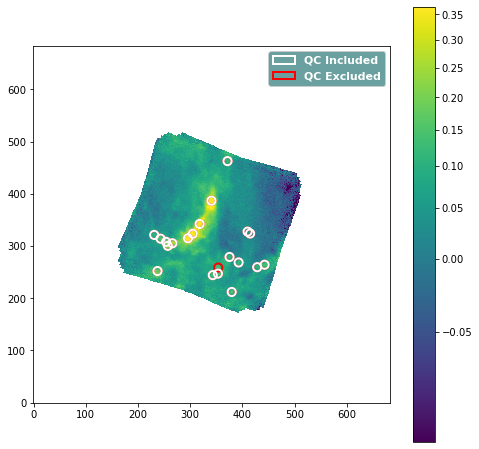

In [349]:
#now let's examine which sources didn't pass the cuts - overplot on the image to see if it looks first order reasonable

#get source coordinates for the snr cut table
cutsc=mtcut['sky_centroid'] 

#Compare which sources are included/excluded
source_aperture =SkyCircularAperture(cutsc, r=6*u.arcsec)

#convert to pixel coords for plotting
pix_aperture_source = source_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)


ap_patches = pix_aperture.plot(color='red', lw=2,
                           label='QC Excluded')
ap_patches_new = pix_aperture_source.plot(color='white', lw=2,
                           label='QC Included')

handles = (ap_patches_new[0],ap_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
          handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

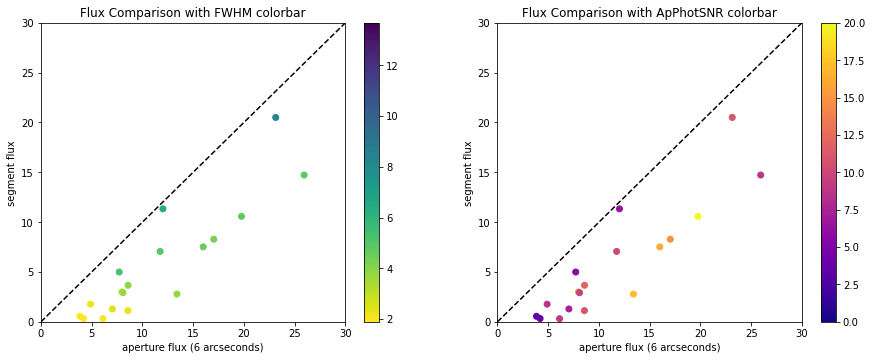

In [350]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with FWHM colorbar')
p1=ax1.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['fwhm']*0.768, cmap='viridis_r')
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (6 arcseconds)')
ax1.set_ylabel('segment flux')
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=20)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (6 arcseconds)')
ax2.set_ylabel('segment flux')
ax2.set_xlim(0,30)
ax2.set_ylim(0,30)


plt.show()

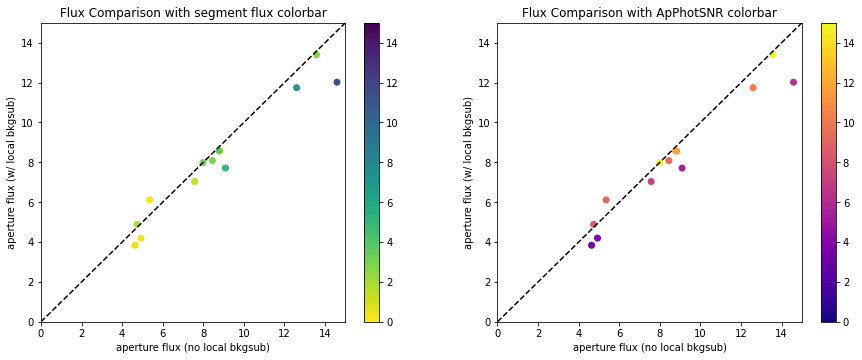

In [351]:
#a few diagnostic plots to examine background contributions to aperture flux
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with segment flux colorbar')
p1=ax1.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['segment_flux'], cmap='viridis_r',vmin=0,vmax=15)
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (no local bkgsub)')
ax1.set_ylabel('aperture flux (w/ local bkgsub)')
ax1.set_xlim(0,15)
ax1.set_ylim(0,15)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=15)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (no local bkgsub)')
ax2.set_ylabel('aperture flux (w/ local bkgsub)')
ax2.set_xlim(0,15)
ax2.set_ylim(0,15)


plt.show()

In [352]:
#write out the resulting table to file
ascii.write(mtcut, fieldconfig.field+'_25um_cat_qcuts.dat', overwrite=True)